In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
%cd drive/My Drive/facial-keypoints-detection
!ls

/content/drive/My Drive/facial-keypoints-detection
 IdLookupTable.csv   model_attention_3M.h5	     model_fnn.h5
 img2.png	     model_attention.h5		     model_fnn.png
 img3.jpg	     model_attention.png	     SampleSubmission.csv
 img4.jpg	    'model_cnn_full_data(1-20).h5'   test.csv
 img5.png	     model_cnn_full_data.h5	     test.zip
 img7.jpg	     model_cnn.h5		     training.csv
 img.png	     model_cnn.png		     training.zip


In [0]:
import os
print(os.listdir())

['SampleSubmission.csv', 'IdLookupTable.csv', 'training.zip', 'training.csv', 'test.csv', 'test.zip', 'model_cnn.h5', 'model_fnn.h5', 'model_attention.h5', 'model_attention_3M.h5', 'model_cnn_full_data.h5', 'model_fnn.png', 'model_cnn.png', 'model_attention.png', 'model_cnn_full_data(1-20).h5', 'img.png', 'img2.png', 'img3.jpg', 'img4.jpg', 'img5.png', 'img7.jpg']


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
from time import sleep
import os

Train_Dir = 'training.csv'
Test_Dir = 'test.csv'
lookid_dir = 'IdLookupTable.csv'
train_data = pd.read_csv(Train_Dir)  
test_data = pd.read_csv(Test_Dir)
lookid_data = pd.read_csv(lookid_dir)
print(os.listdir())

train_data.isnull().any().value_counts()
train_data.fillna(method = 'ffill',inplace = True)
train_data.isnull().any().value_counts()

imag = []
for i in range(0,7049):
    img = train_data['Image'][i].split(' ')
    img = ['0' if x == '' else x for x in img]
    img = img
    # print(type(img))
    imag.append(img)

image_list = np.array(imag,dtype = 'float')
image_list = image_list/255.
X_train = image_list.reshape(-1,96,96,1)


training = train_data.drop('Image',axis = 1)

y_train = []
for i in range(0,7049):
    y = training.iloc[i,:]
    y = (y - 48) / 48
    y_train.append(y)
y_train = np.array(y_train,dtype = 'float')

['SampleSubmission.csv', 'IdLookupTable.csv', 'training.zip', 'training.csv', 'test.csv', 'test.zip', 'model_cnn.h5', 'model_fnn.h5', 'model_attention.h5', 'model_attention_3M.h5', 'model_cnn_full_data.h5', 'model_fnn.png', 'model_cnn.png', 'model_attention.png', 'model_cnn_full_data(1-20).h5', 'img.png', 'img2.png', 'img3.jpg', 'img4.jpg', 'img5.png', 'img7.jpg']


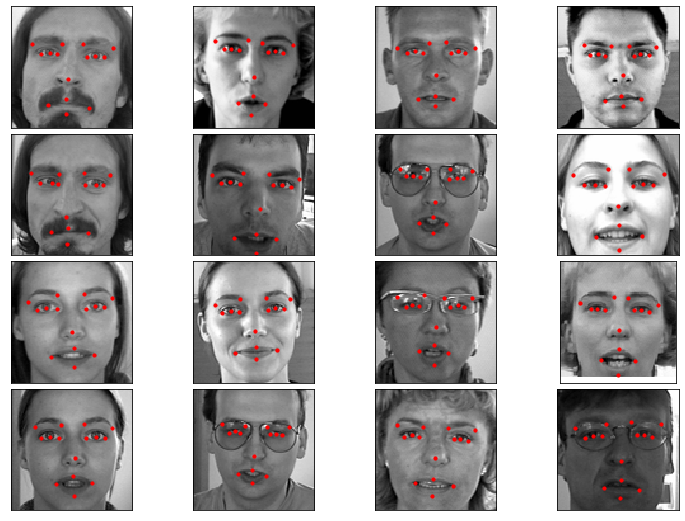

In [0]:
import matplotlib.pyplot as plt

def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2]*48+48, y[1::2]*48+48, marker='o', s=10, c='red')

fig = plt.figure(figsize=(10, 7))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    axis = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    plot_sample(X_train[i], y_train[i], axis)

plt.show()

In [0]:
from keras.layers import Conv2D, UpSampling2D, MaxPool2D, BatchNormalization
from keras.layers import Activation, Add, Multiply, Lambda

Using TensorFlow backend.


In [0]:
def residual_block(input, input_channels=None, output_channels=None, kernel_size=(3, 3), stride=1):
    if output_channels is None:
        output_channels = input.get_shape()[-1].value
    if input_channels is None:
        input_channels = output_channels // 4

    strides = (stride, stride)

    x = BatchNormalization()(input)
    x = Activation('relu')(x)
    x = Conv2D(input_channels, (1, 1))(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(input_channels, kernel_size, padding='same', strides=stride)(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(output_channels, (1, 1), padding='same')(x)

    if input_channels != output_channels or stride != 1:
        input = Conv2D(output_channels, (1, 1), padding='same', strides=strides)(input)

    x = Add()([x, input])
    return x

def attention_block(input, input_channels=None, output_channels=None, encoder_depth=1):
    """
    attention block
    https://arxiv.org/abs/1704.06904
    """

    p = 1
    t = 2
    r = 1

    if input_channels is None:
        input_channels = input.get_shape()[-1].value
    if output_channels is None:
        output_channels = input_channels

    # First Residual Block
    for i in range(p):
        input = residual_block(input)

    # Trunc Branch
    output_trunk = input
    for i in range(t):
        output_trunk = residual_block(output_trunk)

    # Soft Mask Branch

    ## encoder
    ### first down sampling
    output_soft_mask = MaxPool2D(padding='same')(input)  # 32x32
    for i in range(r):
        output_soft_mask = residual_block(output_soft_mask)

    skip_connections = []
    for i in range(encoder_depth - 1):

        ## skip connections
        output_skip_connection = residual_block(output_soft_mask)
        skip_connections.append(output_skip_connection)
        # print ('skip shape:', output_skip_connection.get_shape())

        ## down sampling
        output_soft_mask = MaxPool2D(padding='same')(output_soft_mask)
        for _ in range(r):
            output_soft_mask = residual_block(output_soft_mask)

            ## decoder
    skip_connections = list(reversed(skip_connections))
    for i in range(encoder_depth - 1):
        ## upsampling
        for _ in range(r):
            output_soft_mask = residual_block(output_soft_mask)
        output_soft_mask = UpSampling2D()(output_soft_mask)
        ## skip connections
        output_soft_mask = Add()([output_soft_mask, skip_connections[i]])

    ### last upsampling
    for i in range(r):
        output_soft_mask = residual_block(output_soft_mask)
    output_soft_mask = UpSampling2D()(output_soft_mask)

    ## Output
    output_soft_mask = Conv2D(input_channels, (1, 1))(output_soft_mask)
    output_soft_mask = Conv2D(input_channels, (1, 1))(output_soft_mask)
    output_soft_mask = Activation('sigmoid')(output_soft_mask)
    # output_soft_mask = Activation('relu')(output_soft_mask)

    # Attention: (1 + output_soft_mask) * output_trunk
    output = Lambda(lambda x: x + 1)(output_soft_mask)
    output = Multiply()([output, output_trunk])  #

    # Last Residual Block
    for i in range(p):
        output = residual_block(output)

    return output

In [0]:
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Dense
from keras.layers import AveragePooling2D
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.models import Model
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

def AttentionResNet56(shape=(224, 224, 3), n_channels=64, n_classes=100,
                      dropout=0, regularization=0.01):

    regularizer = l2(regularization)

    input_ = Input(shape=shape)
    x = Conv2D(n_channels, (7, 7), strides=(2, 2), padding='same')(input_) # 112x112
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)  # 56x56

    x = residual_block(x, output_channels=n_channels * 1)  # 56x56
    x = attention_block(x, encoder_depth=2)  # bottleneck 7x7

    x = residual_block(x, output_channels=n_channels * 2, stride=2)  # 28x28
    x = attention_block(x, encoder_depth=2)  # bottleneck 7x7

    x = residual_block(x, output_channels=n_channels * 4, stride=2)  # 14x14
    x = attention_block(x, encoder_depth=1)  # bottleneck 7x7

    x = residual_block(x, output_channels=n_channels * 4, stride=2)  # 7x7
    x = residual_block(x, output_channels=n_channels * 8)
    # x = residual_block(x, output_channels=n_channels * 8)

    pool_size = (x.get_shape()[1].value, x.get_shape()[2].value)
    x = AveragePooling2D(pool_size=pool_size, strides=(1, 1))(x)
    x = Flatten()(x)
    if dropout:
        x = Dropout(dropout)(x)
    output = Dense(n_classes)(x)

    model = Model(input_, output)
    return model

In [0]:
model_attention = AttentionResNet56(shape=(96,96,1), n_channels=32, n_classes=30,dropout=0, regularization=0.01)
model_attention.summary()















Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 48, 48, 32)   1600        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 48, 48, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 48, 48, 32)   0           batch_normalization_1[0][0]      
______________________________________________________________________________

In [0]:
lr_reducer = ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=7, min_lr=10e-7, epsilon=0.01, verbose=1)
early_stopper = EarlyStopping(monitor='val_acc', min_delta=0, patience=15, verbose=1)
callbacks= [lr_reducer, early_stopper]

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [0]:
import keras

model_attention.compile(optimizer=keras.optimizers.Adam(lr=0.0001), 
              loss='mse',
              metrics=['mae','accuracy'])

In [0]:
# model_cnn = CNN()
hist_attention = model_attention.fit(X_train, y_train, nb_epoch=100,batch_size=128, validation_split=0.2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.




Train on 5639 samples, validate on 1410 samples
Epoch 1/100
5639/5639 [==============================] - 41s 7ms/step - loss: 1.1615 - mean_absolute_error: 0.7005 - acc: 0.0745 - val_loss: 0.2378 - val_mean_absolute_error: 0.3740 - val_acc: 0.1702
Epoch 2/100
5639/5639 [==============================] - 7s 1ms/step - loss: 0.1775 - mean_absolute_error: 0.3239 - acc: 0.1623 - val_loss: 0.1391 - val_mean_absolute_error: 0.2869 - val_acc: 0.1816
Epoch 3/100
5639/5639 [==============================] - 7s 1ms/step - loss: 0.1199 - mean_absolute_error: 0.2675 - acc: 0.1929 - val_loss: 0.1087 - val_mean_absolute_error: 0.2532 - val_acc: 0.1752
Epoch 4/100
5639/5639 [==============================] - 7s 1ms/step - loss: 0.0921 - mean_absolute_error: 0.2349 - acc: 0.2137 - val_loss: 0.0888 - val_mean_absolute_error: 0.2299 - val_acc: 0.1816
Epoch 5/100
5639/5639 [==============================] - 7s 1ms/step - loss: 0.0743 - mean_absolute_error: 0.2112 - acc: 0.2307 - val_loss: 0.0765 - val_

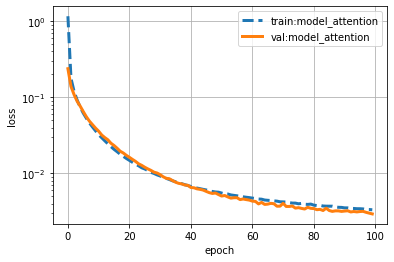

In [0]:
def plot_loss(hist,name,plt,RMSE_TF=False):
    loss = hist['loss']
    val_loss = hist['val_loss']
    if RMSE_TF:
        loss = np.sqrt(np.array(loss))*48 
        val_loss = np.sqrt(np.array(val_loss))*48 
        
    plt.plot(loss,"--",linewidth=3,label="train:"+name)
    plt.plot(val_loss,linewidth=3,label="val:"+name)

plot_loss(hist_attention.history,"model_attention",plt)
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [0]:
from keras.models import load_model
model_attention.save('model_attention(1-20).h5') 

model_attention = load_model('model_attention(1-20).h5')

In [0]:
timag = []
for i in range(0,1783):
    timg = test_data['Image'][i].split(' ')
    timg = ['0' if x == '' else x for x in timg]
    
    timag.append(timg)

In [0]:
timage_list = np.array(timag,dtype = 'float')
timage_list = timage_list/255.
X_test = timage_list.reshape(-1,96,96,1)

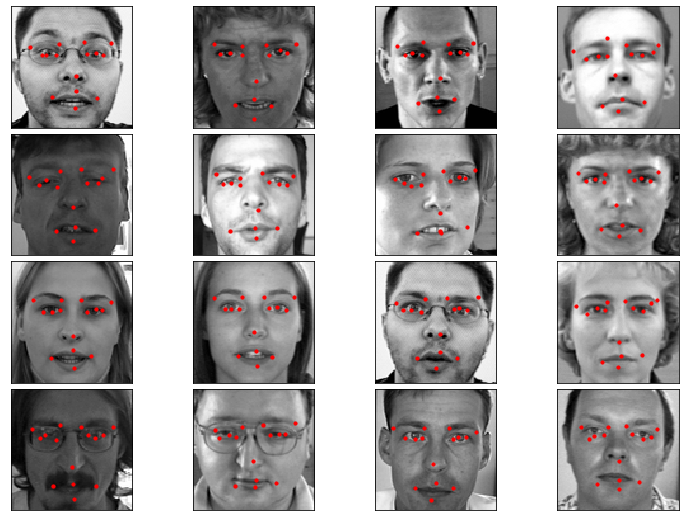

In [0]:
import matplotlib.pyplot as plt

pred = model_attention.predict(X_test)

def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2]*48+48, y[1::2]*48+48, marker='o', s=10, c='red')

fig = plt.figure(figsize=(10, 7))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    axis = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    plot_sample(X_test[i], pred[i], axis)

plt.show()

In [0]:
from keras.utils import plot_model
# from keras.utils.vis_utils import plot_model
plot_model(model_attention, to_file='model_attention.png', show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image(retina=True, filename='model_attention.png')

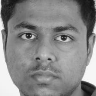

In [0]:
import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread('img2.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (96, 96))

cv2_imshow(img)

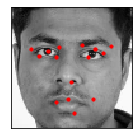

In [0]:
timage_list = np.array(img,dtype = 'float')
timage_list = timage_list/255.
X_test = timage_list.reshape(-1,96,96,1)

pred = model_attention.predict(X_test)

def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2]*48+48, y[1::2]*48+48, marker='o', s=10, c='red')

fig = plt.figure(figsize=(10, 7))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(1):
    axis = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    plot_sample(X_test[i], pred[i], axis)

plt.show()

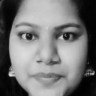

In [0]:
img = cv2.imread('img5.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (96, 96))

cv2_imshow(img)

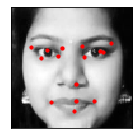

In [0]:
timage_list = np.array(img,dtype = 'float')
timage_list = timage_list/255.
X_test = timage_list.reshape(-1,96,96,1)

pred = model_attention.predict(X_test)

def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2]*48+48, y[1::2]*48+48, marker='o', s=10, c='red')

fig = plt.figure(figsize=(10, 7))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(1):
    axis = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    plot_sample(X_test[i], pred[i], axis)

plt.show()

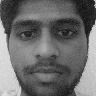

In [0]:
img = cv2.imread('img7.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (96, 96))

cv2_imshow(img)

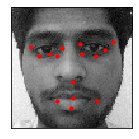

In [0]:
timage_list = np.array(img,dtype = 'float')
timage_list = timage_list/255.
X_test = timage_list.reshape(-1,96,96,1)

pred = model_attention.predict(X_test)

def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2]*48+48, y[1::2]*48+48, marker='o', s=10, c='red')

fig = plt.figure(figsize=(10, 7))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(1):
    axis = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    plot_sample(X_test[i], pred[i], axis)

plt.show()